In [1]:
from phantom import phantom3d
import matplotlib.pyplot as plt
import numpy as np
import napari
from R2_3d import compute_R2_3d
from R1_3d import compute_R1_3d
from simAcquireAllKSlines import simAcquireAllKSlines

simulating the phantom based on prior average data

In [2]:
phantom_vol = phantom3d(n=128)
plt.imshow(phantom_vol[64], cmap='gray')
plt.title("Central slice of 3D phantom")
plt.axis('off')
plt.show()
anime = napari.view_image(phantom_vol, name='3D Phantom', colormap='gray')

C:\Users\mshojaei\AppData\Local\Temp\ipykernel_22544\277892336.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Creating the model parameters

In [3]:
R1_3d = compute_R1_3d(); R1_3d.shape; napari.view_image(R1_3d[...,0], name='R1_3d', colormap='gray')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [4]:
R2_3d = compute_R2_3d(); R2_3d.shape; napari.view_image(R2_3d[...,0], name='R2_3d', colormap='gray')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [5]:
R1_3d = 2 * (R1_3d - R1_3d.min()) / (R1_3d.max() - R1_3d.min()) - 1
R2_3d = 2 * (R2_3d - R2_3d.min()) / (R2_3d.max() - R2_3d.min()) - 1

R1_mag = np.array([2, 4, 5])
R2_mag = np.array([2, 4, 5])

R1_true = np.zeros_like(R1_3d)
R2_true = np.zeros_like(R2_3d)

R1_true[...,0] = R1_mag[0] * R1_3d[...,0]
R1_true[...,1] = R1_mag[1] * R1_3d[...,1]
R1_true[...,2] = R1_mag[2] * R1_3d[...,2]

R2_true[...,0] = R2_mag[0] * R2_3d[...,0]
R2_true[...,1] = R2_mag[1] * R2_3d[...,1]
R2_true[...,2] = R2_mag[2] * R2_3d[...,2]

importing the surrogate signals

In [6]:
data = np.loadtxt('proj_CV_delCV.txt')
S1 = -data[:, 1]
S2 = -data[:, 2]

# Define sequence of k-space lines (here full coverage repeated 3 times)
KS_lines = list(range(128))
KS_lines = KS_lines + KS_lines + KS_lines
# Ensure surrogate arrays match number of lines
S1_acq = S1.copy(); S2_acq = S2.copy()
while len(S1_acq) < len(KS_lines):
    S1_acq = np.concatenate([S1_acq, S1_acq])
    S2_acq = np.concatenate([S2_acq, S2_acq])
S1_acq = S1_acq[:len(KS_lines)]
S2_acq = S2_acq[:len(KS_lines)]

# Plot surrogate signals
plt.figure()
plt.plot(S1_acq, label='S1')
plt.plot(S2_acq, label='S2', color='red')
plt.title('Surrogate signals')
plt.legend()
plt.show()

C:\Users\mshojaei\AppData\Local\Temp\ipykernel_22544\822051527.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


simulating the k-space

In [7]:
run_sim = False
if run_sim:
    KS_acq, anim_mov_acq = simAcquireAllKSlines(phantom_vol, R1_3d, R2_3d, S1_acq, S2_acq, KS_lines, noise=0.05, anim=True, save=True)
else:
    KS_acq = np.load("KS_acq.npy")

In [8]:
# import numpy as np
# np.save("KS_acq.npy", KS_acq)


In [9]:
from save_anim import save_animation


save_anim = False
if save_anim:
    # Assuming anim_mov_acq is a numpy array of shape (T, H, W)
    save_animation(anim_mov_acq, output_path='m/my_animation.mp4', fps=15)


In [10]:
# from IPython.display import Video, display
# display(Video("anim.mp4", embed=True, width=1000, height=1000))


fitting

In [11]:
lims_R1_x = (float(np.min(R1_true[..., 0])), float(np.max(R1_true[..., 0])))
lims_R1_y = (float(np.min(R1_true[..., 1])), float(np.max(R1_true[..., 1])))
lims_R1_z = (float(np.min(R1_true[..., 2])), float(np.max(R1_true[..., 2])))

lims_R2_x = (float(np.min(R2_true[..., 0])), float(np.max(R2_true[..., 0])))
lims_R2_y = (float(np.min(R2_true[..., 1])), float(np.max(R2_true[..., 1])))
lims_R2_z = (float(np.min(R2_true[..., 2])), float(np.max(R2_true[..., 2])))

In [ ]:
from fitModelAndNonIterMCRToKSlines import fitModelAndNonIterMCRToKSlines


I_rec, R1_fit, R2_fit, anim_mov_fit = fitModelAndNonIterMCRToKSlines(KS_acq, S1_acq, S2_acq, KS_lines,
                                                                    anim=True,
                                                                    lims_R1_x=lims_R1_x, lims_R1_y=lims_R1_y, lims_R1_z=lims_R1_z,
                                                                    lims_R2_x=lims_R2_x, lims_R2_y=lims_R2_y, lims_R2_z=lims_R2_z,
                                                                    I_size=phantom_vol.shape, C_thresh=0.001)


=== Level 1 ===============================


e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\MCRFromKSlinesUsingAdj.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show(block=False)
e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\MCRFromKSlinesUsingAdj.py:43: RuntimeWarning: invalid value encountered in divide
  I_def = I_def / weights
  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
100%|██████████| 384/384 [03:21<00:00,  1.91it/s]


Saved MP4 to I_rec_test2_level_1/anim.mp4
[Level 1] initial loss C = 6.893574e+17

[Level 1] Iteration 0
  -> current loss C = 6.893574e+17
   Testing step size 1.0


  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
100%|██████████| 384/384 [03:15<00:00,  1.96it/s]


Saved MP4 to I_rec_test2_level_1/anim_1.0.mp4
     -> improved! new loss = 6.852196e+17


  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
100%|██████████| 384/384 [03:14<00:00,  1.98it/s]


Saved MP4 to I_rec_test2_level_1/anim_1.0.mp4
   Testing step size 0.5


  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
100%|██████████| 384/384 [03:15<00:00,  1.96it/s]


Saved MP4 to I_rec_test2_level_1/anim_0.5.mp4
   Testing step size 0.25


  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
100%|██████████| 384/384 [03:16<00:00,  1.95it/s]


Saved MP4 to I_rec_test2_level_1/anim_0.25.mp4
   Testing step size 0.125


  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
100%|██████████| 384/384 [03:14<00:00,  1.98it/s]


Saved MP4 to I_rec_test2_level_1/anim_0.125.mp4
   Testing step size 0.0625


  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
100%|██████████| 384/384 [03:22<00:00,  1.90it/s]


Saved MP4 to I_rec_test2_level_1/anim_0.0625.mp4
   Testing step size 0.03125


  0%|          | 0/384 [00:00<?, ?it/s]e:\Codes\DLPipeline\MM_SuPReMo_Test_Py\3D_implementation\simAcquireAllKSlines.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.pause(0.001)
  9%|▊         | 33/384 [00:16<03:00,  1.95it/s]

In [12]:
I_rec_mag = np.abs(I_rec)
import SimpleITK as sitk
I_rec_mag_img = sitk.GetImageFromArray(I_rec_mag)
sitk.WriteImage(I_rec_mag_img, "I_rec_test1.nii.gz")

In [15]:
import SimpleITK as sitk
R1_fit_img = sitk.GetImageFromArray(R1_fit)
sitk.WriteImage(R1_fit_img, "R1_fit_test1.nii.gz")

In [16]:
import SimpleITK as sitk
R2_fit_img = sitk.GetImageFromArray(R2_fit)
sitk.WriteImage(R2_fit_img, "R2_fit_test1.nii.gz")

In [18]:
len(anim_mov_fit)

3

In [29]:
plt.imsave("fig3.png", anim_mov_fit[2])

In [24]:
from save_anim import save_animation

save_animation(anim_mov_fit, output_path='frame_test/my_animation.mp4', fps=10)

Saved MP4 to frame_test/my_animation.mp4


In [31]:
napari.view_image(np.abs(I_rec), name='Reconstructed', colormap='gray')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [37]:
napari.view_image(R2_fit[...,0], name='R2_fit', colormap='gray')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [39]:
np.save("I_rec.npy", I_rec)

In [43]:
napari.view_image(np.abs(I_rec)-phantom_vol, name='Difference', colormap='viridis')

Viewer(camera=Camera(center=(0.0, np.float64(63.5), np.float64(63.5)), zoom=np.float64(4.453125), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(63.0), 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(127.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(63.0), np.float64(63.0), np.float64(63.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), laye

In [46]:
# import napari
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
# from qtpy.QtWidgets import QFrame, QVBoxLayout

# # your data
# diff = np.abs(I_rec) - phantom_vol

# # 1) create the viewer and add your image
# viewer = napari.Viewer()
# layer = viewer.add_image(diff, name='Difference', colormap='viridis')

# # 2) make a tiny Matplotlib Figure for the colorbar
# fig = plt.figure(figsize=(1, 4))
# ax = fig.add_axes([0.05, 0.05, 0.3, 0.9])

# # make the ScalarMappable with the same colormap & contrast limits
# norm = plt.Normalize(vmin=layer.contrast_limits[0],
#                      vmax=layer.contrast_limits[1])
# sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
# sm.set_array([])

# # draw the colorbar into that ax
# fig.colorbar(sm, cax=ax)

# # 3) put the Figure onto a Qt widget and dock it
# canvas = FigureCanvasQTAgg(fig)
# container = QFrame()
# container.setLayout(QVBoxLayout())
# container.layout().addWidget(canvas)
# viewer.window.add_dock_widget(container, name='Colorbar', area='right')

# napari.run()


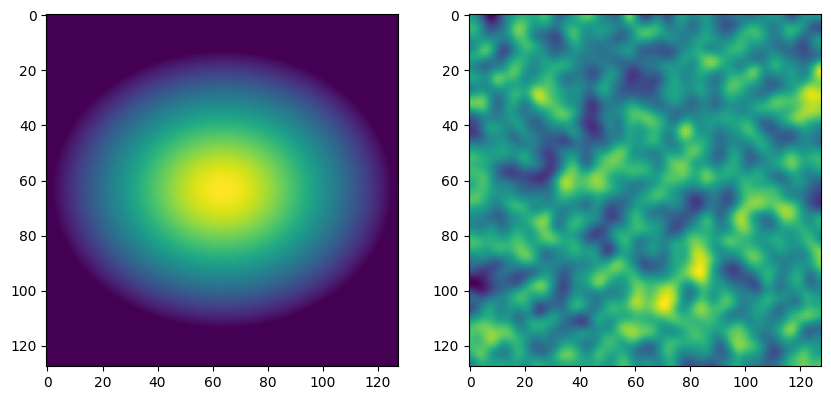

In [60]:
# ...existing code...
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(R2_3d[64, ..., 2])
ax[1].imshow(R2_fit[64, ..., 2])
# ...existing code...